<left><img width=25% src="img/cornell_tech2.svg"></left>

# Lecture 16: Neural Networks

### Applied Machine Learning

__Volodymyr Kuleshov, Jin Sun, and Brandon Amos__<br>Cornell Tech

In [1]:
import numpy as np; np.set_printoptions(precision=2)
import matplotlib.pyplot as plt; #plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams.update({ "figure.figsize": [8, 3], "figure.dpi": 125, "text.usetex": True, "font.family": "Helvetica" })
import pandas as pd; pd.options.display.float_format = "{:,.2f}".format
import warnings; warnings.filterwarnings('ignore')

# Part 1: An Artificial Neuron

Neural networks are machine learning algorithms inspired by the brain.

We will start by defining building blocks for these algorithms, and draw connections to neuroscience.

# Review: Binary Classification

In supervised learning, we fit a model of the form
$$ f : \mathcal{X} \to \mathcal{Y} $$
that maps inputs $x \in \mathcal{X}$ to targets $y \in \mathcal{Y}$.

In classification, the space of targets $\mathcal{Y}$ is *discrete*. Classification is binary if $\mathcal{Y} = \{0,1\}$

# A Biological Neuron

In order to define an artificial neuron, let's look first at a biological one.

<center>
<img width=60% src="img/nns/bio-neuron.png">
</center>

* Each neuron receives input signals from its dendrites
* If input signals are strong enough, neuron fires output along its axon, which connects to the dendrites of other neurons.

# An Artificial Neuron: Example

We can imitate this machinery using an idealized artificial neuron.
* Dendrite $j$ gets signal $x_j$; modulates multiplicatively to $w_j \cdot x_j$.
* The body of the neuron sums the modulated inputs: $\sum_{j=1}^d w_j \cdot x_j$.
* These go into the activation function that produces an output.
<center>
<img width="55%" src="img/nns/aneuron.jpeg">
</center>

# An Artificial Neuron: Notation

A neuron is a model $f : \mathbb{R}^d \to \mathbb{R}$, with the following components:
* Inputs $x_1,x_2,...,x_d$, denoted by a vector $x$.
* Weight vector $w \in \mathbb{R}^d$ that modulates input $x$ as $w^\top x$.
* An activation function $\sigma: \mathbb{R} \to \mathbb{R}$ that outputs $\sigma(w^\top x)$ based on the sum of modulated features $w^\top x$.

# Perceptron

If we use a step function as the activation function, we obtain the classic Perceptron model:

$$ f(x) = 
\begin{cases}
  1 & \text{if $w^\top x>0$}, \\
  0 & \text{otherwise}
\end{cases}
$$

This models a neuron that fires if the inputs are sufficiently large, and doesn't otherwise.

We can visualize the activation function of the Perceptron.

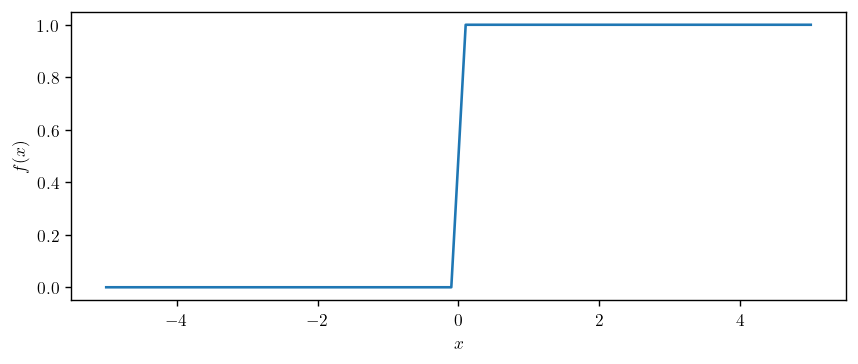

In [2]:
step_fn = lambda z: 1 if z > 0 else 0
z = np.linspace(-5, 5)
plt.plot(z, [step_fn(zi) for zi in z])
plt.xlabel('$x$'); plt.ylabel('$f(x)$');

The sigmoid activation function encodes the idea of a neuron firing if the inputs exceed a threshold, makes make the activation function "smooth".

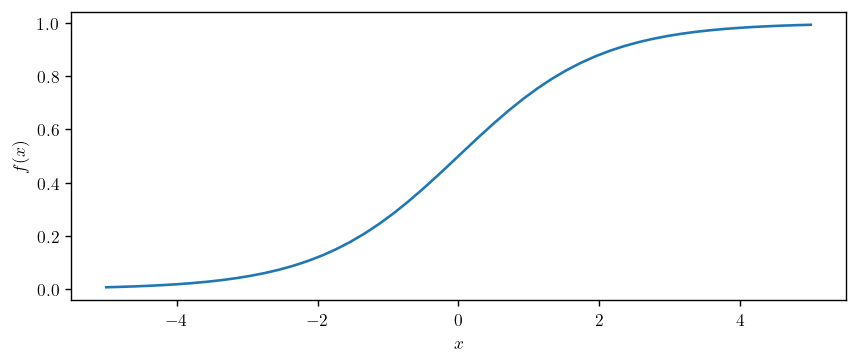

In [3]:
sigma = 1/(1+np.exp(-z))
plt.plot(z, sigma)
plt.xlabel('$x$'); plt.ylabel('$f(x)$');

# Activation Functions

There are many other activation functions that can be used. In practice, these two work better than the sigmoid:
* Hyperbolic tangent (`tanh`): $\sigma(z) = \tanh(z)$
* Rectified linear unit (`ReLU`): $\sigma(z) = \max(0, z)$
<!-- * Leaky `ReLU`: $$\sigma(z) = \max(\alpha z, z),$$ where $\alpha$ is a small constant such as 0.1. -->

We can easily visualize these.

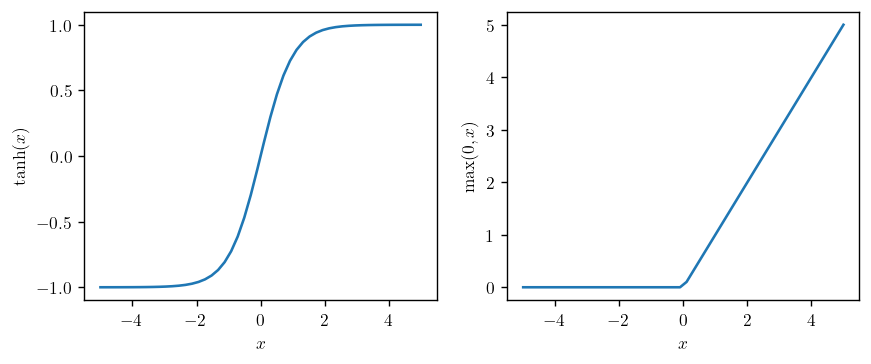

In [4]:
plt.subplot(121)
plt.plot(z, np.tanh(z))
plt.xlabel('$x$'); plt.ylabel(r'${\rm tanh}(x)$');
plt.subplot(122)
plt.plot(z, np.maximum(z, 0));
plt.xlabel('$x$'); plt.ylabel(r'$\max(0, x)$');

# Logistic Regression as an Artificial Neuron

Logistic regression is a model of the form
$$ f(x) = \sigma(w^\top x) = \frac{1}{1 + \exp(-w^\top x)}, $$
that can be interpreted as a neuron that uses the *sigmoid* as the activation function.

# Classification Dataset: Iris Flowers

To demonstrate classification algorithms, we are going to use the Iris flower dataset. 

We are going to define an artificial neuron for the binary classification problem (class-0 vs the rest).

In [5]:
# https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html
from sklearn import datasets

iris = datasets.load_iris(as_frame=True)
iris_X, iris_y = iris.data, iris.target

# rename class two to class one
iris_y2 = iris_y.copy()
iris_y2[iris_y2==2] = 1

X = iris_X.to_numpy()[:,:2]
Y = iris_y2

This is a visualization of the dataset.

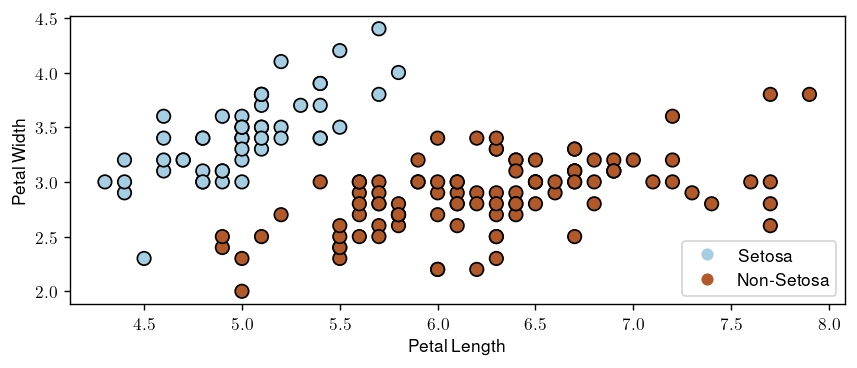

In [6]:
# Plot also the training points
p1 = plt.scatter(X[:,0], X[:,1], c=iris_y2, edgecolor='k', s=60, cmap=plt.cm.Paired)
plt.xlabel('Petal Length'); plt.ylabel('Petal Width')
plt.legend(handles=p1.legend_elements()[0], labels=['Setosa', 'Non-Setosa'], loc='lower right');

Below, we define neuron with a sigmoid activation function (and its gradient).

In [7]:
def neuron(X, theta):
    activation_fn = lambda z: 1/(1+np.exp(-z))
    return activation_fn(X.dot(theta))

def gradient(theta, X, y):
    return np.mean((y - neuron(X, theta)) * X.T, axis=1)

We can optimize is using gradient descent.

In [8]:
threshold = 5e-5
step_size = 1e-1

theta, theta_prev, iter = np.zeros((3,)), np.ones((3,)), 0
iris_X['one'] = 1 # add a vector of ones for the bias
X_train = iris_X.iloc[:,[0,1,-1]].to_numpy()
y_train = iris_y2.to_numpy()

while np.linalg.norm(theta - theta_prev) > threshold:
    if iter % 50000 == 0:
        print('Iteration %d.' % iter)
    theta_prev = theta
    grad = gradient(theta, X_train, y_train)
    theta = theta_prev + step_size * grad
    iter += 1

Iteration 0.
Iteration 50000.
Iteration 100000.
Iteration 150000.
Iteration 200000.


This neuron learns a linear decision boundary that separates the data.

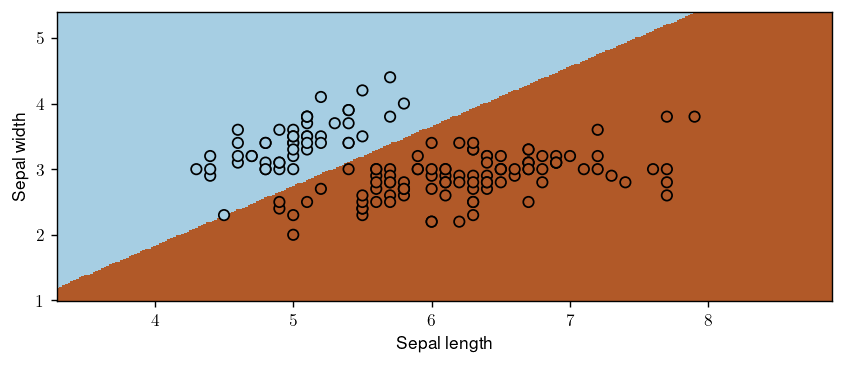

In [9]:
# generate predictions over a grid:
xx, yy = np.meshgrid(np.arange(3.3, 8.9, 0.02), np.arange(1.0, 5.4, 0.02))
Z = neuron(np.c_[xx.ravel(), yy.ravel(), np.ones(xx.ravel().shape)], theta)
Z[Z<0.5] = 0
Z[Z>=0.5] = 1

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel('Sepal length'); plt.ylabel('Sepal width');

# Algorithm: Artificial Neuron

* __Type__: Supervised learning (regression and classification).
* __Model family__: Linear model followed by non-linear activation.
* __Objective function__: Any differentiable objective.
* __Optimizer__: Gradient descent.
* __Special Cases__: Logistic regression, Perceptron

<left><img width=25% src="img/cornell_tech2.svg"></left>
# Part 2: Artificial Neural Networks

Let's now see how we can connect neurons into networks that form complex models that further mimic the brain.

# Review: Artificial Neuron

We say that a neuron is a model $f : \mathbb{R}^d \to [0,1]$, with the following components:
* Inputs $x_1,x_2,...,x_d$, denoted by a vector $x$.
* Weight vector $w \in \mathbb{R}^d$ that modulates input $x$ as $w^\top x$.
* An activation function $\sigma: \mathbb{R} \to \mathbb{R}$ that computes the output $\sigma(w^\top x)$ of the neuron based on the sum of modulated features $w^\top x$.

# Review: Logistic Regression as Neuron

Logistic regression is a model of the form
$$ f(x) = \sigma(\theta^\top x) = \frac{1}{1 + \exp(-\theta^\top x)}, $$
that can be interpreted as a neuron that uses the *sigmoid* as the activation function.

# Neural Networks: Intuition

A neural network is a directed graph in which a node is a neuron that takes as input the outputs of the neurons that are connected to it.
<center>
<img src="img/nns/net-intro.png">
</center>
Networks are typically organized in layers.

# Neural Networks: Layers

A layer $f : \mathbb{R}^d \to \mathbb{R}^p$ applies $p$ neurons in parallel to an input $x$.

$$ f(x) = \begin{bmatrix}
\sigma(w_1^\top x) \\
\sigma(w_2^\top x) \\
\vdots \\
\sigma(w_p^\top x)
\end{bmatrix}.
$$

The $w_k$ are weights if neuron $k$; we say $p$ is the *size* of the layer.

The first output of the layer is a neuron with weights $w_1$:
<center>
<img src="img/nns/layers-1.png" width=60%>
</center>    

The second neuron has weights $w_2$:
<center>
<img src="img/nns/layers-2.png" width=60%>
</center>    

The third neuron has weights $w_3$:
<center>
<img src="img/nns/layers-3.png" width=60%>
</center>    
The parameters of the layer are $w_1, w_2, w_3$.

We can also combine weights into one $W$:
<center>
<img src="img/nns/layers-4.png" width=60%>
</center>    

We can combine the $w_k$ into one matrix $W$:

$$f(x) = \sigma(W\cdot x) = \begin{bmatrix}
\sigma(w_1^\top x) \\
\sigma(w_2^\top x) \\
\vdots \\
\sigma(w_p^\top x)
\end{bmatrix},
$$

where $\sigma(W\cdot x)_k = \sigma(w_k^\top x)$. <!--and $W_{kj} = (w_k)_j$. -->

# Neural Networks: Notation

A neural network $f : \mathbb{R}^d \to \mathbb{R}$ is a composition of $L$ layers:

$$ f(x) = f_L \circ f_{L-1} \circ \ldots f_l \circ \ldots f_1 (x). $$

The notation $f \circ g(x)$ denotes the composition $f(g(x))$ of functions.

We can visualize this graphically as follows.

<center>
<img src="img/nns/layers-L.png" width=100%>
</center>    

# Example of a Neural Network

Let's implement a small two layer neural net with 3 hidden units.

<center>
<img src="img/nns/nn-example.png" width=60%>
</center>    

This implementation looks as follows.

In [10]:
# a two layer network with logistic function as activation
class Net():
    def __init__(self, x_dim, W_dim):
        # weight matrix for layer 1
        self.W = np.random.normal(size=(x_dim, W_dim))
        # weight matrix for layer 2, also the output layer
        self.V = np.random.normal(size=(W_dim, 1))
        # activation function
        self.afunc = lambda x: 1/(1+np.exp(-x))
    
    def predict(self, x):
        # get output of the first layer
        l1 = self.afunc(np.matmul(x, self.W))
        # get output of the second layer, also the output layer
        out = self.afunc(np.matmul(l1, self.V))
        return out

Later in this lecture, we will see how to train this model using gradient descent.

# Types of Neural Network Layers

Here are some possible types of neural network layers:
* **Output layer:** normally has one neuron & special activation function
* **Input layer:** normally, this is just the input vector $x$.
* **Hidden layer:** Any layer between input and output.
* **Dense layer:** A layer in which every input is connected to every neuron.
* **Convolutional layer:** A layer in which the operation $w^\top x$ implements a mathematical [convolution](https://en.wikipedia.org/wiki/Convolution).
* **Recurrent Layer:** A layer in which the output is connected back to the input.
* **Attention Layer:** A layer that weights the output based on the input.

# Types of Neural Network Layers

<center>
<img width="70%" src="./img/layers.png"></img><br/>
<span style="color: grey">Source: https://theaisummer.com/attention/</span>
</center>

# Algorithm: (Fully-Connected) Neural Network

* __Type__: Supervised learning (regression and classification).
* __Model family__: Compositions of layers of artificial neurons.
* __Objective function__: Any differentiable objective.
* __Optimizer__: Gradient descent.

# Pros and Cons of Neural Nets

Neural networks are very powerful models.
* They are flexible, and can approximate any function.
* They work well over unstructured inputs like audio or images.
* They can achieve state-of-the-art performance.

They also have important drawbacks.
* They can also be slow and hard to train.
* Large networks require a lot of data.

<left><img width=25% src="img/cornell_tech2.svg"></left>
# Part 3: Backpropagation

Backpropagation is an algorithm for efficiently computing the gradient of multi-layer neural network in order to train using gradient descent.

# Motivating Example: A Toy Network

Consider the following operations that output $e$ from inputs $a, b$:
\begin{align*}
c = a + b && d = b + 1 && e = c \cdot d
\end{align*}

We can represent this as a computational graph (figures by [Chris Olah](http://colah.github.io/posts/2015-08-Backprop)):

<center>
<img src="img/olah_graph1.png" width=50%>
</center>

Let's say we want to compute $e$ from $a=2, b=1$. We can start from the leaves and work our way up as follows:

<center>
<img src="img/olah_graph2.png" width=60%>
</center>

# The Chain Rule of Calculus

Suppose that we now want to compute derivatives within this computational graph. We can leverage the chain rule of calculus.

If we have two differentiable functions $f(x)$ and $g(x)$, and $$F(x) = f \circ g (x)$$ then the derivative of $F(x)$ is:
$$ F^\prime (x) = f^\prime (g(x)) \cdot g^\prime (x).$$

Let $y=f(u)$ and $u=g(x)$, we also have:
$$ \frac{dy}{dx} = \frac{dy}{du} \frac{du}{dx}.$$

# Derivatives in Our Toy Example

Consider our toy example. We can add the derivative of the output of each node with respect to its input along each edge of the graph.
<center>
<img src="img/olah_graph3.png" width=60%>
</center>

<center>
<img src="img/olah_graph3.png" width=60%>
</center>
If we want to compute the derivative of the output with respect to the input, we can multiply the partial derivatives along its path:

$$\frac{\partial e}{\partial a} = \frac{\partial e}{\partial c} \frac{\partial c}{\partial a} = 2 \cdot 1$$

<center>
<img src="img/olah_graph3.png" width=60%>
</center>

If we have multiple paths to the root, we sum them all (a total derivative!):
$$\frac{\partial e}{\partial b} = \frac{\partial e}{\partial c} \frac{\partial c}{\partial b} + \frac{\partial e}{\partial d} \frac{\partial d}{\partial b} = 2 \cdot 1 + 3 \cdot 1$$

The key ideas here are that:
* We did one feed-forward pass to compute node values and one backward pass to compute edge derivatives.
* The two passes precompute information that lets us calculate derivatives very efficiently (in linear time) via *dynamic programming*.

This is a special case of an algorithm called *backpropagation*.

# Derivatives in Neural Networks

Recall that a neural network is a model $f : \mathbb{R} \to \mathbb{R}$ that consists of a composition of $L$ neural network layers:
$$ f(x) = f_L \circ f_{L-1} \circ \ldots f_1 (x). $$
The final layer $f_L$ has size one (assuming the neural net has one output); intermediary layers $f_l$ can have any number of neurons.

The notation $f \circ g(x)$ denotes the composition $f(g(x))$ of functions

A neural network layer is a model $f_l : \mathbb{R}^d \to \mathbb{R}^p$ that applies $p$ neurons in parallel to an input $x$.
$$f_l(x) = \sigma(W_l\cdot x) = \begin{bmatrix}
\sigma(w_{l1}^\top x) \\
\sigma(w_{l2}^\top x) \\
\vdots \\
\sigma(w_{lp}^\top x)
\end{bmatrix},
$$
where each $w_{lk}$ is the vector of weights for the $k$-th neuron. We want to compute the derivatives of $J$ with respect to all the weights.

# Derivatives in Neural Networks

Let $J(w)$ be the objective function (e.g., mean squared error).

* We use $w_{lkj}$ to denote to weight of the connection between neuron $k$ in layer $l$ and its $j$-th input.
* Let $y_{lk}$ denote the output of $k$-th neuron in layer $l$.

We can visualize this graphically. This is a full neural network:

<img src="img/nns/layers-L.png" width=100%>

This is a zoom-in on two consecutive layers:
<center>
<img src="img/nns/layers-3b.png" width=70%>
</center>
We use $k$ and $j$ to index the neurons in each layer.

Let $J$ be the objective function. We seek to compute:

* the derivative with respect to each weight $w_{lkj}$
$$\frac{\partial J}{\partial w_{lkj}}$$
* the derivative with respect to the output of $j$-th neuron in layer $l$
$$\frac{\partial J}{\partial y_{lj}}$$

# Backpropagation

Backpropagation is an algorithm for computing all $\partial J / \partial{w_{lkj}}$ in two steps:
1. In the forward pass, we start from the input $x$ and compute the output $y_l$ of each layer.

2. In the backward pass, we start from the top and recursively compute the following partial derivatives:
\begin{align*}
\frac{\partial J}{\partial y_{lk}} && \frac{\partial J}{\partial w_{lkj}}.
\end{align*}
<!-- where $y_{lk}$ is the output of the $k$-th neuron in layer $l$, and  $\partial w_{lkj}$ is the $kj$-th weight in layer $l$. -->

We compute the two sets of partial derivatives using the following recursive formulas for $l = L-1,L-2,...,1$:

\begin{align*}
\frac{\partial J}{\partial y_{lj}} & = \sum_{k=1}^p \frac{\partial J}{\partial y_{l+1, k}} \cdot \frac{\partial y_{l+1, k}}{\partial y_{lj}}  && \text{(total derivative})\\
\frac{\partial J}{\partial w_{lkj}} & = \frac{\partial J}{\partial y_{lk}} \cdot \frac{\partial y_{lk}}{\partial w_{lkj}} && \text{(chain rule})
\end{align*}

Note that $\frac{\partial y_{lk}}{\partial w_{lkj}}$ and $\frac{\partial y_{l+1, k}}{\partial y_{lj}}$ are local derivatives of a neuron (can be easily computed) and the $\frac{\partial J}{\partial y_{l+1, k}}$ are available from the previous step. When $l=L$, these  are easy-to-compute derivatives the output neuron.

We compute the partial derivatives recursively:
\begin{align*}
\frac{\partial J}{\partial y_{lj}} & = \sum_{k=1}^p \frac{\partial J}{\partial y_{l+1, k}} \cdot \frac{\partial y_{l+1, k}}{\partial y_{lj}}  && \text{(total derivative})
\end{align*}

* Note that $\frac{\partial J}{\partial y_{l+1, k}}$ is already computed at step $l+1$.

* It's easy to compute $\frac{\partial y_{l+1, k}}{\partial y_{lj}}$ using calculus.

Observe that $\frac{\partial y_{l+1, k}}{\partial y_{lj}}$ is the derivative of the output of a neuron with respect to its input. 

For a dense layer:
\begin{align*}
\frac{\partial y_{l+1, k}}{\partial y_{lj}} 
& = \frac{\partial}{\partial y_{lj}} \sigma(w_{l+1, k}^\top y_l) \\
& = \sigma'(w_{l+1, k}^\top y_l) \cdot w_{l+1, k, j}
\end{align*}

We can now use this to compute the main derivative we seek:
\begin{align*}
\frac{\partial J}{\partial w_{lkj}} & = \frac{\partial J}{\partial y_{lk}} \cdot \frac{\partial y_{lk}}{\partial w_{lkj}} && \text{(chain rule})
\end{align*}

* Note that $\frac{\partial J}{\partial y_{lk}}$ is the derivative we just computed.

* It's also easy to compute $\frac{\partial y_{l+1, k}}{\partial w_{lkj}}$ using calculus.

$\frac{\partial y_{l+1, k}}{\partial w_{lkj}}$ is the derivative of the output of a neuron with respect to its weight $w_{lkj}$. 

For a dense layer:
\begin{align*}
\frac{\partial y_{lk}}{\partial w_{lkj}} 
& = \frac{\partial}{\partial w_{lkj}} \sigma(w_{lk}^\top y_{l-1}) \\
& = \sigma'(w_{lk}^\top y_l) \cdot y_{l-1, j}
\end{align*}

# Backpropagation by Hand

Let's work out by hand what backpropagation would do on our two layer neural network.

<center>
<img width="30%" src="img/nns/backprop/backprop-twolayers-figure0.png"/>
</center>

For our two layer fully connected network with sigmoid activation, the network is composed of following functions:

$$\mathbf{h} = \sigma(\mathbf{W}^T \mathbf{x})$$
$$y = \sigma(\mathbf{V}^T \mathbf{h}),$$

where $\mathbf{x} = [x_1,x_2]^T, \mathbf{h} = [h_1,h_2,h_3]^T, \mathbf{W} \in \mathbb{R}^{2\times3}, \mathbf{V} \in \mathbb{R}^{3\times1}$, and $\sigma$ is the sigmoid function.

In our example, we have the following values:

$\mathbf{x} = [5.0,3.0]^T,~~~~\hat{y} = 1$ means it is positive class.

$\mathbf{W} = \begin{bmatrix}
1.0 & -1.0 & 3.0\\ 
2.0 & 2.0 & -1.0
\end{bmatrix}$

$\mathbf{V} = [0.1,0.5,-0.1]^T$

<center>
<img width="45%" src="img/nns/backprop/backprop-twolayers-figure1.png"/>
</center>

We can compute the output of the hidden layer, $\mathbf{h}$:

$h_1 = \sigma (W_{11} \cdot x_1 + W_{21} \cdot x_2) = \sigma (1.0\times5.0 + 2.0\times3.0) = 0.9999$

<center>
<img width="45%" src="img/nns/backprop/backprop-twolayers-figure2.png">
</center>

We can compute the output of the hidden layer, $\mathbf{h}$:

\begin{align*}
h_2 &= \sigma (W_{12} \cdot x_1 + W_{22} \cdot x_2) = \sigma (-1.0\times5.0 + 2.0\times3.0) = 0.7310
\end{align*}

<center>
<img width="45%" src="img/nns/backprop/backprop-twolayers-figure3.png">
</center>

We can compute the output of the hidden layer, $\mathbf{h}$:

\begin{align*}
h_3 &= \sigma (W_{13} \cdot x_1 + W_{23} \cdot x_2) = \sigma (3.0\times5.0 + -1.0\times3.0) = 0.9999
\end{align*}

<center>
<img width="45%" src="img/nns/backprop/backprop-twolayers-figure4.png">
</center>

Similarly we can get the output of $y$:

$$y = \sigma (V_1 \cdot h_1 + V_2 \cdot h_2 + V_3 \cdot h_3) = 0.590378$$

Next, we want to compute the gradient with respect to each of the parameters of this network.

Consider first computing the gradients of the weights in the output layer:
$$\frac{\mathrm{d}J}{\mathrm{d}{V}} = \frac{\mathrm{d}J}{\mathrm{d}{y}} \frac{\mathrm{d}y}{\mathrm{d}{V}}$$
In order to compute $\frac{\mathrm{d}J}{\mathrm{d}{V}}$ we can separately compute $\frac{\mathrm{d}J}{\mathrm{d}{y}}$ and $\frac{\mathrm{d}y}{\mathrm{d}{V}}$.

Let's start with $\frac{\mathrm{d}J}{\mathrm{d}{y}}$. Recall that the binary cross-entropy loss is:
\begin{align*}
J(y, \hat{y}) = - \hat{y} \cdot \log (y) - (1-\hat{y})\cdot (1-\log (y))
\end{align*}

The derivative with respect to $y$ when $\hat y = 1$ and $y=0.59$ is:
\begin{align*}
J(y, \hat{y}) = - \log (y) = 0.5269
&&
\frac{\mathrm{d}J}{\mathrm{d}{y}} = - 1/y = -1.6938
\end{align*}

We will start denoting in red the derivatives $\partial J / \partial v$ of the objective $J$ with respect to the each variable $v$.

<center>
<img width="45%" src="img/nns/backprop/backprop-twolayers-figure5.png">
</center>

Above, we have added in red $\partial J / \partial y$ at node $y$.

Next, we want to compute $\frac{\mathrm{d}y}{\mathrm{d}{V}}$.

<center>
<img width="45%" src="img/nns/backprop/backprop-twolayers-figure5.png">
</center>

Recall: $y = \sigma(\mathbf{V}^T \mathbf{h}) = \sigma (V_1 h_1 + V_2 h_2 + V_3 h_3)$ and $\sigma' = \sigma(1-\sigma)$:

$$\frac{\partial y}{\partial V_1} = y (1-y) h_1,~~\frac{\partial y}{\partial V_2} = y (1-y) h_2,~~\frac{\partial y}{\partial V_3} = y (1-y) h_3$$

<!-- <center>
<img width="700" src="img/nns/backprop/backprop-twolayers-figure6.png">
</center> -->
Applying these formulas, we obtain the gradients of $\mathbf{V}$:

\begin{align*}
\frac{\partial J}{\partial V_1} &= \frac{\mathrm{d}J}{\mathrm{d}{y}} \frac{\partial y}{\partial V_1} = -1.69 \times 0.59 \times (1-0.59) \times 0.99998 = -0.41\\
\frac{\partial J}{\partial V_2} &= \frac{\mathrm{d}J}{\mathrm{d}{y}} \frac{\partial y}{\partial V_2} = -1.69 \times 0.59 \times (1-
0.59) \times 0.7311 = -0.30\\
\frac{\partial J}{\partial V_3} &= \frac{\mathrm{d}J}{\mathrm{d}{y}} \frac{\partial y}{\partial V_3} = -1.69 \times 0.59 \times (1-0.59) \times 0.99999 = -0.41
\end{align*}

<center>
<img width="45%" src="img/nns/backprop/backprop-twolayers-figure6.png">
</center>

We denote these in orange on the edges of the computational graph.

Next, let's compute gradients at the hidden layer:
$$\frac{\mathrm{d}J}{\mathrm{d}{h}} = \frac{\mathrm{d}J}{\mathrm{d}{y}} \frac{\mathrm{d}y}{\mathrm{d}{h}}$$

Similarly to the previous slide:
\begin{align*}
\frac{\partial J}{\partial h_1} &= \frac{\mathrm{d}J}{\mathrm{d}{y}} \frac{\partial y}{\partial h_1} = -1.69 \times 0.59 \times (1-0.59) \times 0.1 = -0.04096\\
\frac{\partial J}{\partial h_2} &= \frac{\mathrm{d}J}{\mathrm{d}{y}} \frac{\partial y}{\partial h_2} = -1.69 \times 0.59 \times (1-
0.59) \times 0.5 = -0.2048\\
\frac{\partial J}{\partial h_3} &= \frac{\mathrm{d}J}{\mathrm{d}{y}} \frac{\partial y}{\partial h_3} = -1.69 \times 0.59 \times (1-0.59) \times -0.1 = 0.04096
\end{align*}
<!-- From now on we can ignore the output layer, as we have everything we need to compute gradients in layers ahead. -->

<center>
<img width="45%" src="img/nns/backprop/backprop-twolayers-figure7.png">
</center>

We add these in red on the graph. Crucially, all the downstream derivatives can be computed from these derivatives without using any upstream nodes.

Since we have another linear layer with sigmoid activation, the way we compute gradients will be the same as before:

\begin{align*}
\frac{\partial J}{\partial h_1} \frac{\partial h_1}{\partial W_{11}} &= -0.041 \times 0.99998 \times (1-0.99998) \times 5 = -3\times10^{-6} \\
\frac{\mathrm{d}J}{\mathrm{d}{h_1}} \frac{\partial h_1}{\partial W_{12}} &= -0.041 \times 0.99998 \times (1-
0.99998) \times 3 = -2\times10^{-6}
\end{align*}

<center>
<img width="45%" src="img/nns/backprop/backprop-twolayers-figure8.png">
</center>

We denote these in purple on the computational graph.

<center>
<img width="45%" src="img/nns/backprop/backprop-twolayers-figure9.png">
</center>

We can compute all the other gradients in the same way.

<!-- Note the gradients to the weights connecting to $h_2$ are larger in magnitude than others.  -->

<center>
<img width="45%" src="img/nns/backprop/backprop-twolayers-figure10.png">
</center>

And now we have the gradients to all the learnable weights in this two layer network and we can tune the weights by gradient descent.

The gradients tell us how much to change for each weight so that the loss will become smaller. 

# Backpropagation in Numpy

Now let's implement backprop with the simple neural network model we defined earlier.

We start by implementing the building block of our network: a linear layer with sigmoid activation.

In [11]:
import numpy as np

# a single linear layer with sigmoid activation
class LinearSigmoidLayer():
    def __init__(self, in_dim, out_dim):
        self.W = np.random.normal(size=(in_dim,out_dim))
        self.W_grad = np.zeros_like(self.W)
        
        self.afunc = lambda x: 1. / (1. + np.exp(-x))
    
    # forward function to get output
    def forward(self, x):
        Wx = np.matmul(x, self.W)
        self.y = self.afunc(Wx)
        self.x = x
        return self.y        
        
    # backward function to compute gradients
    # grad_out is dJ/dy, where y is the layer's output
    # grad_in is dJ/dx, where x is the layer's output
    # the gradient dJ/dW is saved to self.W_grad
    def backward(self, grad_out):  
        self.W_grad = np.matmul(
            self.x.transpose(), 
            self.y * (1-self.y) * grad_out,
            )
        grad_in = np.matmul(
            self.y * (1-self.y) * grad_out,
            self.W.transpose()
            )
        
        return grad_in

Then we can stack the single layers to construct a two layer network.

In [12]:
# a two layer network with logistic function as activation
class Net():
    def __init__(self, x_dim, W_dim):
        self.l1 = LinearSigmoidLayer(x_dim, W_dim)
        self.l2 = LinearSigmoidLayer(W_dim, 1)
    
    # get output
    def predict(self, x):
        h = self.l1.forward(x)
        self.y = self.l2.forward(h)
        return self.y
    
    # backprop
    def backward(self, label):
        # binary cross entropy loss, and gradients
        if label == 1:
            J = -1*np.log(self.y)
            dJ = -1/self.y
        else:
            J = -1*np.log(1-self.y)
            dJ = 1/(1-self.y)
            
        # back propagation
        dJdh = self.l2.backward(dJ) # output --> hidden
        dJdx = self.l1.backward(dJdh) # hidden --> input
        return J
    
    # update weights according to gradients
    def grad_step(self, lr=1e-4):
        self.l1.W -= lr*self.l1.W_grad
        self.l2.W -= lr*self.l2.W_grad     

We can run with our previous example to check if the results are consistent with our manual computation.

In [13]:
model = Net(2, 3)
model.l1.W = np.array([[1.0,-1.0,3.0],[2.0,2.0,-1.0]])
model.l2.W = np.array([[0.1],[0.5],[-0.1]])

x = np.array([5.0, 3.0])[np.newaxis,...]
x_label = 1

# forward
out = model.predict(x)

# backward
loss = model.backward(label=x_label)

print('loss: {}'.format(loss))
print('W grad: {}'.format(model.l1.W_grad))
print('V grad: {}'.format(model.l2.W_grad))

loss: [[0.53]]
W grad: [[-3.42e-06 -2.01e-01  1.26e-06]
 [-2.05e-06 -1.21e-01  7.55e-07]]
V grad: [[-0.41]
 [-0.3 ]
 [-0.41]]


Another sanity check is to perform gradient descent on the single sample input and see if we can achieve close to zero loss.

You can try to change the target label below to see the network is able to adapt in either case.

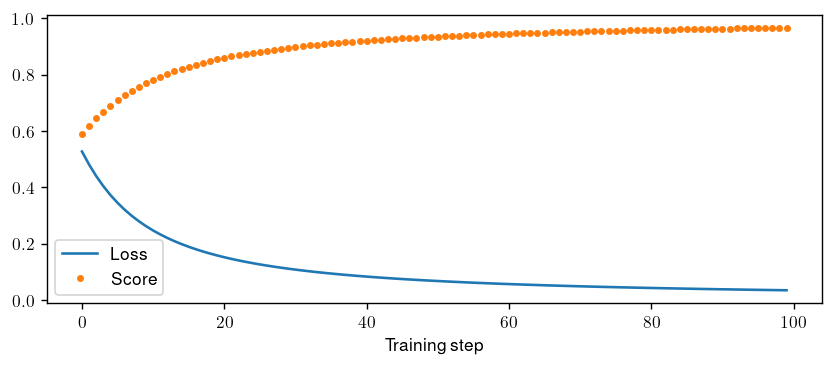

In [14]:
## gradient descent
loss = []
score = []
for i in range(100):
    out = model.predict(x)
    loss.append(model.backward(label=1)) # 1 for positive, 0 for negative
    model.grad_step(lr=1e-1)
    score.append(out)
    
plt.plot(np.array(loss).squeeze(), '-', label='Loss')
plt.plot(np.array(score).squeeze(), '.', label='Score')
plt.legend(); plt.xlabel('Training step');

# Summary

* Neural networks are powerful models that can approximate any function.
* They are trained using gradient descent.
* In order to compute gradients, we use an efficient algorithm called backpropagation.
* **Next**: ConvNets, ResNets, RNNs, Transformers